# Customer Insights in Fashion Retail using NLP
### Objective
This notebook performs topic modeling and sentiment analysis on customer reviews to help a retail brand gain insights into customer perceptions and preferences.

#### Goals:
- Use Latent Dirichlet Allocation (LDA) for topic modeling
- Apply Aspect-Based Sentiment Analysis (ABSA) for granular insights on high-priority topics


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Load SpaCy model for lemmatization
nlp = spacy.load('en_core_web_sm')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Satvik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Load and Preprocess the Dataset
This step loads the dataset and preprocesses the review text with tokenization, stopword removal, and lemmatization.


In [2]:
# Load the dataset
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
df = df.dropna(subset=['Review Text'])

# Define a SpaCy-based lemmatization function
def spacy_lemmatize(text):
    doc = nlp(text.lower())
    lemmatized = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(lemmatized)

# Apply preprocessing to 'Review Text'
df['Cleaned_Review'] = df['Review Text'].apply(spacy_lemmatize)
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Cleaned_Review
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful silky sexy comfortable
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretty happen find store g...
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress want work initially order peti...
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit fun flirty fabulous ti...
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flattering adjustable tie perfect length...


## 2. Vectorization
Convert the preprocessed text data into a document-term matrix for LDA topic modeling.


In [3]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(df['Cleaned_Review'])
feature_names = vectorizer.get_feature_names_out()
print(f"Document-Term Matrix Shape: {dtm.shape}")

Document-Term Matrix Shape: (22641, 2565)


## 3. Building and Training the LDA Model
Run LDA with different topic numbers and evaluate coherence to find the optimal topic number.


Number of Topics: 5, Coherence Score: 0.2130
Number of Topics: 10, Coherence Score: 0.1737
Number of Topics: 15, Coherence Score: 0.1573
Number of Topics: 20, Coherence Score: 0.1532


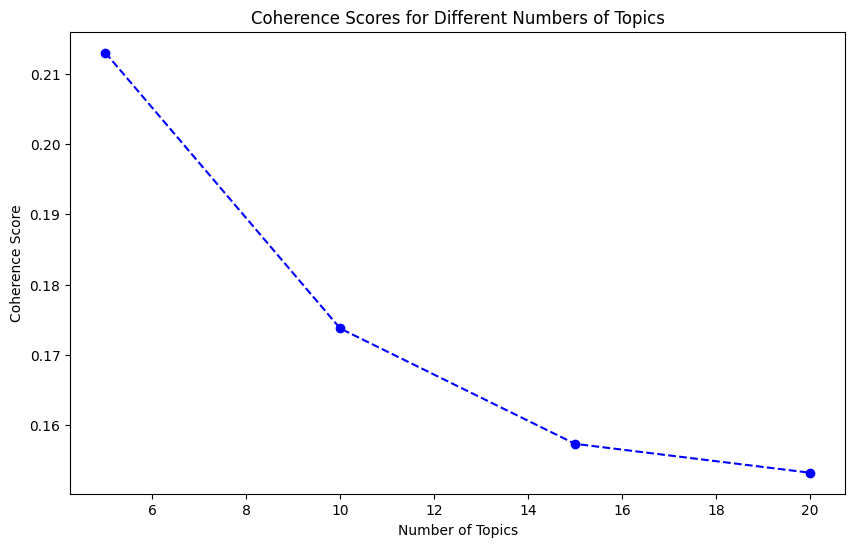

Best Coherence Score: 0.21300168560633553


In [4]:
# Define grid search function for optimal topic count
def grid_search_lda(dtm, feature_names, topic_range, max_iter=20):
    best_model = None
    best_coherence = -1
    coherence_scores = []
    
    for n_topics in topic_range:
        lda_model = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=max_iter,
            learning_method='batch'
        )
        lda_model.fit(dtm)
        
        # Calculate coherence for the model
        coherence = calculate_coherence(lda_model, dtm, feature_names, top_n=10)
        coherence_scores.append(coherence)
        print(f"Number of Topics: {n_topics}, Coherence Score: {coherence:.4f}")
        
        if coherence > best_coherence:
            best_coherence = coherence
            best_model = lda_model
    
    # Plot coherence scores
    plt.figure(figsize=(10, 6))
    plt.plot(topic_range, coherence_scores, marker='o', linestyle='--', color='blue')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores for Different Numbers of Topics")
    plt.show()
    
    return best_model, best_coherence

# Calculate coherence based on cosine similarity for the top words
def calculate_coherence(model, dtm, feature_names, top_n=10):
    coherence_scores = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-top_n - 1:-1]
        top_words_vectors = dtm[:, top_features_ind].toarray().T
        distances = pairwise_distances(top_words_vectors, metric='cosine')
        coherence = 1 - distances[np.triu_indices(top_n, 1)].mean()
        coherence_scores.append(coherence)
    avg_coherence = np.mean(coherence_scores)
    return avg_coherence

# Define the range for number of topics and perform grid search
topic_range = range(5, 25, 5)
best_lda_model, best_coherence = grid_search_lda(dtm, feature_names, topic_range)
print(f"Best Coherence Score: {best_coherence}")

## 4. Aspect-Based Sentiment Analysis
Identify aspects (like fit, color, material) in reviews and perform sentiment analysis on each aspect within high-priority topics.


In [5]:
# Define aspect terms
aspect_terms = {
    "fit": ["fit", "size", "comfortable"],
    "color": ["color", "shade", "tone"],
    "material": ["material", "fabric", "texture"],
    "design": ["design", "style", "pattern"]
}

# Aspect-Based Sentiment Analysis
def aspect_based_sentiment_analysis(review_text, aspect_terms):
    aspect_sentiments = {aspect: [] for aspect in aspect_terms.keys()}
    sentences = nltk.sent_tokenize(review_text)
    
    for sentence in sentences:
        for aspect, keywords in aspect_terms.items():
            if any(keyword in sentence for keyword in keywords):
                sentiment_score = sia.polarity_scores(sentence)['compound']
                aspect_sentiments[aspect].append(sentiment_score)
    
    averaged_sentiments = {aspect: np.mean(scores) if scores else 0 
                           for aspect, scores in aspect_sentiments.items()}
    return averaged_sentiments

df['Aspect_Sentiments'] = df['Review Text'].apply(lambda x: aspect_based_sentiment_analysis(x, aspect_terms))
print(df[['Review Text', 'Aspect_Sentiments']].head())

                                         Review Text  \
0  Absolutely wonderful - silky and sexy and comf...   
1  Love this dress!  it's sooo pretty.  i happene...   
2  I had such high hopes for this dress and reall...   
3  I love, love, love this jumpsuit. it's fun, fl...   
4  This shirt is very flattering to all due to th...   

                                   Aspect_Sentiments  
0  {'fit': 0.8932, 'color': 0, 'material': 0, 'de...  
1  {'fit': 0, 'color': 0, 'material': 0, 'design'...  
2  {'fit': 0.14175, 'color': 0, 'material': 0, 'd...  
3  {'fit': 0, 'color': 0, 'material': 0, 'design'...  
4  {'fit': 0, 'color': 0, 'material': 0, 'design'...  


## 5. Visualization and Analysis
Visualize sentiment distribution for each aspect.


C:\Users\Satvik\AppData\Local\Temp\ipykernel_26828\2986373579.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aspect_averages.index, y=aspect_averages.values, palette="coolwarm")


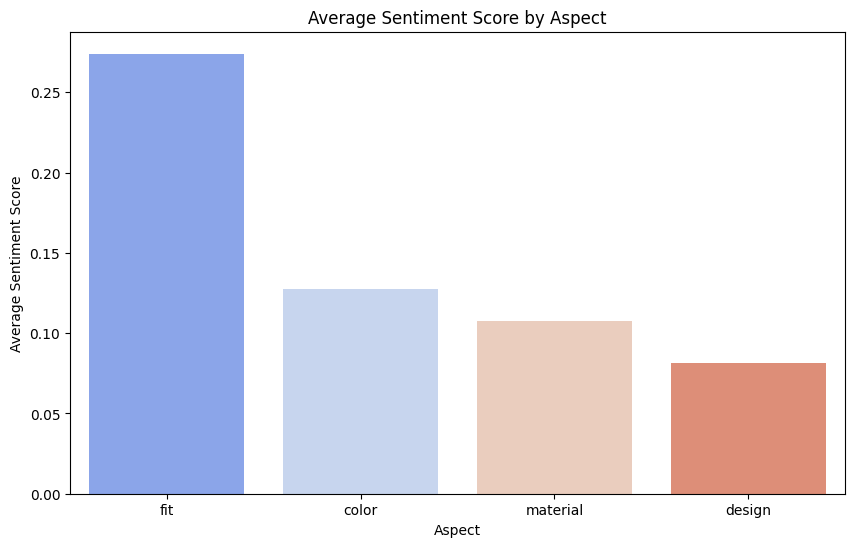

In [6]:
# Convert aspect sentiments to separate columns and visualize
aspect_sentiments_df = pd.json_normalize(df['Aspect_Sentiments'])
df = pd.concat([df, aspect_sentiments_df], axis=1)

# Calculate average sentiment per aspect and plot
aspect_averages = df[aspect_sentiments_df.columns].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=aspect_averages.index, y=aspect_averages.values, palette="coolwarm")
plt.xlabel("Aspect")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score by Aspect")
plt.show()